### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
pd.pandas.set_option('display.max_columns', None)

from scipy import stats
from sklearn.linear_model import LassoCV
from datetime import datetime, timedelta

from plotly import express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import Video, Image

import matplotlib
from matplotlib.colors import LinearSegmentedColormap

import shap
from BorutaShap import BorutaShap
from lightgbm import LGBMRegressor

----
### Loading data




In [2]:
df = pd.read_csv(os.path.join('data/sedal_4_tables_merged.csv'))
#df_assets_carrousel = pd.read_csv(os.path.join('data/assets_id_carrusel.csv'))
#
#for i,id in enumerate(df.assetId.unique()):
#    if id in df_assets_carrousel.asset_id.values:
#        df = df.loc[df.assetId!=id]

df = df.rename(columns={
    'id':'tag_id',
    'name':'tag_name',
    'assetId':'asset_id',
    'tagType':'tag_type'
})

df = df.loc[df.impressions > df.impressions.quantile(0.1)]

df = df.loc[df.tag_type!='TEXT']
df = df.loc[df.tag_type!='SUPER_NOUN']
df = df.loc[df.tag_type!='SUPER_ADJ']
df = df.loc[df.tag_type!='SUPER_VERB']
df = df.loc[df.tag_type!='COLORFULNESS']
df = df.loc[df.tag_type!='BRIGHTNESS']

#df = df.loc[df.tag_type!='LOGO_SPATIAL']
#df = df.loc[df.tag_type!='LOGO']
#df = df.loc[df.tag_type!='LOGO_TEMPORAL_PCT']
#df = df.loc[df.tag_type!='LOGO_TEMPORAL_SEC']

df['ctr'] = df.clicks.values / df.impressions.values
df['cpc'] = df.spend.values / df.clicks.values
df['vtr'] = df.video_views.values / df.impressions.values

df.loc[df['clicks'] == 0, 'cpc'] = 0
df.loc[df['impressions'] == 0, 'ctr'] = 0
df.loc[df['impressions'] == 0, 'vtr'] = 0

df['ctr'] = df['ctr']*100
df['vtr'] = df['vtr']*100

df.tag_name = df.tag_name.astype(str)
df.tag_name = df.tag_name.str.lower()

In [3]:
unique_id_list = []
tags_list = []

df_face = df.loc[df.tag_type=='FACE']
df_face = df_face.rename(columns={'detectionId':'detection_id'})
df_face = df_face.reset_index(drop=True)

for i,detec_id in enumerate(df_face.detection_id):
    if df_face['asset_id'][i] in unique_id_list:
        if detec_id != df_face['detection_id'][i-1]:
            tags_list[index].append('-')
        tags_list[index].append(df_face['tag_name'][i])
    else:
        unique_id_list.append(df_face['asset_id'][i])
        index = unique_id_list.index(df_face['asset_id'][i])
        element_list = [df_face['tag_name'][i]]
        tags_list.append(element_list)

face_tags = {'asset_id': unique_id_list, 'tags': tags_list}

df_face_tags = pd.DataFrame(face_tags)

In [4]:
df_face_tags['tags2'] = ''

for i in range(len(df_face_tags.asset_id.values)):
    df_face_tags['tags2'][i] = []

for i1,tag_list in enumerate(df_face_tags.tags.values):
    if len(tag_list) != 1:
        for i in range(len(tag_list)-1):
            if tag_list[i] != '-':
                if tag_list[i+1] != '-':
                    df_face_tags['tags2'][i1].append(' '.join([tag_list[i],tag_list[i+1]]))
                else:
                    df_face_tags['tags2'][i1].append(tag_list[i])
        if tag_list[len(tag_list)-2] == '-':
            df_face_tags['tags2'][i1].append(tag_list[len(tag_list)-1])
    else:
        df_face_tags['tags2'][i1] = tag_list

df_face_tags['tags'] = df_face_tags['tags2'].copy()
df_face_tags.drop(columns={'tags2'}, inplace=True)

In [5]:
list_assets_id = []
list_elem = []

for i,tag_list in enumerate(df_face_tags.tags.values):
    for elem in tag_list:
        list_assets_id.append(df_face_tags.loc[i, 'asset_id'])
        list_elem.append(elem)


data = {'asset_id': list_assets_id, 'tag_name': list_elem}
df_face_tags = pd.DataFrame(data)

In [6]:
def remove_duplicates(string):
    # Convertir el string en una lista de palabras
    words = string.split()
    # Convertir la lista de palabras en un conjunto
    words_set = set(words)
    # Volver a unir las palabras en un string
    return " ".join(words_set)

def sort_words(string):
    # Convertir el string en una lista de palabras
    words = string.split()
    # Ordenar las palabras en orden alfabético
    words.sort()
    # Volver a unir las palabras en un string
    return " ".join(words)

In [7]:
for i,tag_list in enumerate(df_face_tags.tag_name):
    df_face_tags.tag_name[i] = remove_duplicates(tag_list)
    df_face_tags.tag_name[i] = sort_words(df_face_tags.tag_name[i])
df_face_tags['tag_type'] = 'FACE'

In [8]:
#df_face_tags_shap = pd.merge(df_face_tags, df[['tag_id', 'asset_id', 'start_time_stamp', 'end_time_stamp', 'start_frame',
#                                          'end_frame', 'ad_id', 'published_date', 'brand_name', 's3_url',
#                                          'file_type', 'carrousel_position', 'ctr', 'cpc', 'vtr', 'weight']].drop_duplicates(subset=['asset_id']), how='left', on='asset_id')

df_face_tags_shap = pd.merge(df_face_tags, df[['tag_id', 'asset_id', 'startTimestamp', 'endTimestamp', 'startFrame',
                                          'endFrame', 'ad_id', 'ctr', 'cpc', 'vtr', 'adrecallScore', 'brandAssociationIndex']].drop_duplicates(subset=['asset_id']), how='left', on='asset_id')

---
### Processing target metric

In [9]:
metric = input('Set the metric to be analyzed: ')
metric = metric.replace("Set the metric to be analyzed: ", "")

if metric=='vtr':
    df = df.loc[df.file_type=='video']
elif metric=='bai':
    df = df.loc[df.bai!='no_data']
    df.bai = df.bai.astype(float)
    df = df.loc[df.bai!=0]

print(f"-------You choose {metric.upper()}-------")

-------You choose CTR-------


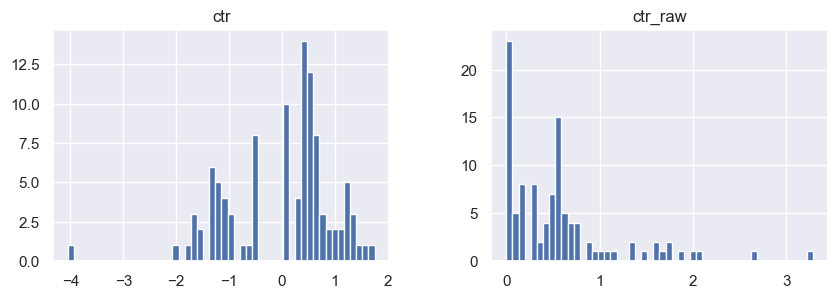

In [10]:
# Parameters ------------------------
index_col = ['asset_id']
shift_to_zero = True
print_metric = True
transform = True
transform_coef = 1e-3
figsize=(10,3)
#------------------------------------

metrics = df_face_tags_shap[index_col+[metric]].groupby(index_col).first() 
metrics[metric+"_raw"] = (df_face_tags_shap[index_col + [metric]].groupby(index_col).first()).replace([np.inf, -np.inf], 0)

if transform:
  metrics[[metric]] = np.log(metrics[[metric]] + transform_coef)

if shift_to_zero:
  m = metrics[metric].mean()
  s = metrics[metric].std()
  metrics[metric] = ((metrics[metric] - m) / s).fillna(0)

if print_metric:
  metrics.hist(column=metrics.columns, bins=50, figsize=figsize, layout=(1,2))

### Preprocessing data

In [11]:
# PARAMETROS MODIFICABLES ----------------------------------------------------------
tag_type_col = 'tag_type'
tag_name_col = 'tag_name'
tag_id_col = 'tag_id'

# Genero tabla dinamica
tags = (df_face_tags_shap.pivot_table(index=index_col, columns=[tag_type_col, tag_name_col],
                        values=tag_id_col, aggfunc='count').fillna(0) > 0).\
                        astype(int).\
                        replace([np.inf, -np.inf], 0)                          

tags_freq = tags.sum(0).reset_index().rename(columns={'tag_type':'tag_group',
                                                      'tag_name':'tag',
                                                       0:'usage_frequency'})

tags_aux = tags.copy()
tags_aux.columns = tags_aux.columns.droplevel()
tags_aux = tags_aux.loc[:,~tags_aux.columns.duplicated()]

print(f"Number of assets: {len(tags_aux)}")
print(f"Number of tags: {len(tags_aux.columns)}")

Number of assets: 104
Number of tags: 90


## SHAP

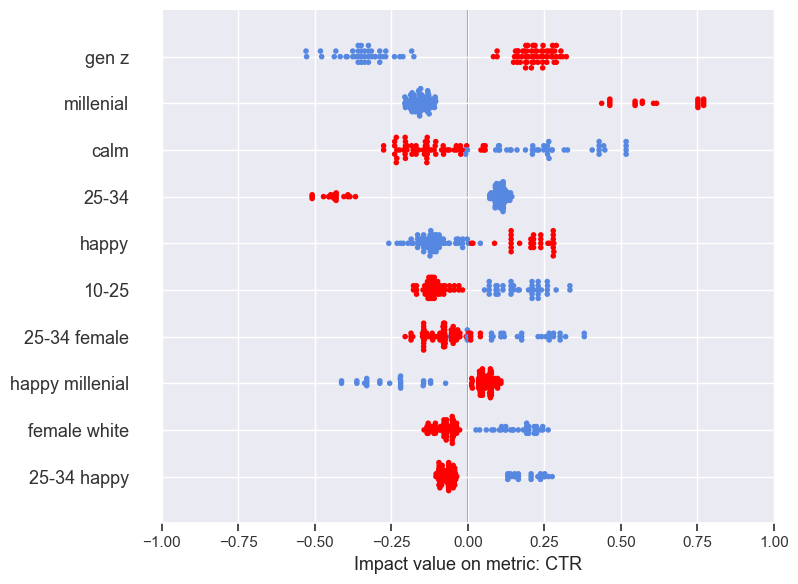

In [13]:
#weights = df_face_tags_shap[['asset_id', 'weight']].groupby('asset_id').first().iloc[:,0]

model = LGBMRegressor(boosting_type='gbdt',
                              max_depth=3,
                              n_estimators=100,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1, random_state=0)

#model.fit(X=tags_aux, y=metrics[metric], sample_weight=weights)
model.fit(X=tags_aux, y=metrics[metric])

explainer = shap.Explainer(model, tags_aux)
shap_values = explainer(tags_aux)

colors = [(1, 0, 0), (86/255, 135/255, 225/255)]
n_bin = 100
cmap_parameter = LinearSegmentedColormap.from_list(name='name_list', colors=colors, N=n_bin)
shap.summary_plot(shap_values, tags_aux, plot_type="dot", max_display=10, plot_size=(8,6), show=False, cmap=cmap_parameter, color_bar=False)
plt.xlim(-1,1)
plt.xlabel(f'Impact value on metric: {metric.upper()}')
#plt.savefig(f'Img/face_beeswarm_for_{metric}.png')
plt.show()

### Calculating score values 

In [14]:
tags_freq = tags.sum(0).reset_index().rename(columns={'tag_type':'tag_group', 'tag_name':'tag', 0:'usage_frequency'})
tags_freq["usage_frequency"] = tags_freq.usage_frequency / len(tags)
tags_freq = tags_freq.drop_duplicates(subset=['tag'])

tags_score_per_asset = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
tags_score_per_asset['asset_id'] = tags_aux.reset_index().asset_id.copy()

list_of_mean_tags = []
for col in tags_aux.columns:
    tag_mean = tags_aux[col].loc[tags_aux[col]==1].reset_index().drop(columns={col}).merge(tags_score_per_asset[[col, 'asset_id']], on='asset_id', how='inner').mean()[0]
    list_of_mean_tags.append(tag_mean)

data = {'tag': tags_aux.columns, 'tag_mean': list_of_mean_tags}

df_sign = pd.DataFrame(data)

shap_results = pd.DataFrame({'score':tags_score_per_asset.drop(columns={'asset_id'}).abs().mean()})
shap_results = shap_results.reset_index().rename(columns={'index':'tag'})

for i,value in enumerate(df_sign.tag_mean):
    if value<0:
        shap_results['score'][i] = shap_results['score'][i]*(-1)


shap_results = pd.merge(shap_results, tags_freq, how='inner', on='tag')
shap_results['period'] = 'all'
shap_results['metric'] = metric

### Bar plot impact value

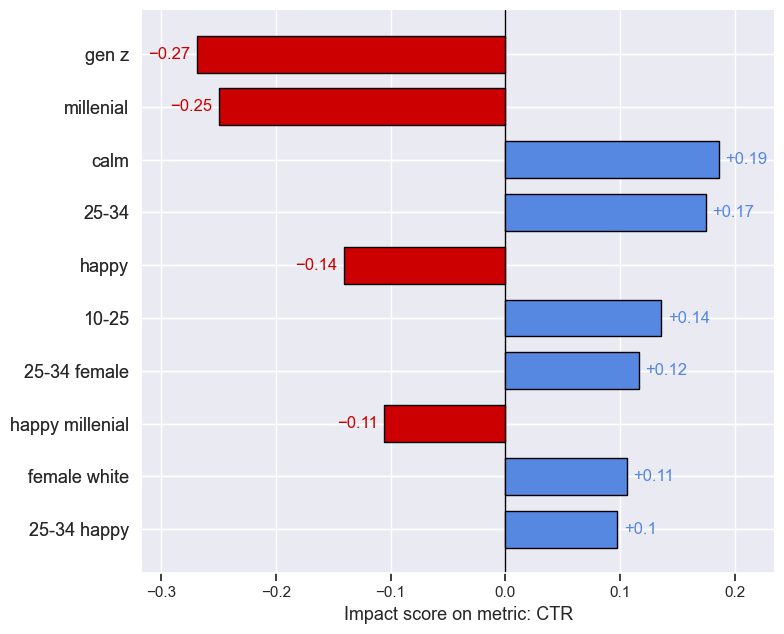

In [15]:
import copy
shap_values_modified = copy.deepcopy(shap_values)
shap_values_modified.values[0] = shap_results.score.values
shap.plots.bar(shap_values_modified[0], neg_color='#CC0000', pos_color='#5687E1', max_display=10, show_sum_of_features=False, edge_color='black', show=False)
#plt.xlim(-1,1)
plt.xlabel(f'Impact score on metric: {metric.upper()}')
plt.tight_layout()
#plt.savefig(f'Img/bar_plot_for_{metric}.png')
plt.show()

### Significant tests

In [16]:
results = shap_results.copy()

results["Score sign"] = results["score"].apply(lambda x: "Positive" if x > 0 else "Negative")
results.rename(columns={"score":"Score", "metric":"Metric", "tag_group":"Tag type", "tag":"Tag name"}, inplace=True)
results["Tag name"] = results["Tag name"].apply(lambda x: x.replace("excessive ice", "icee"))

results.head(5)

,Tag name,Score,Tag type,usage_frequency,period,Metric,Score sign
0,0-9,0.000000,FACE,0.028846,all,ctr,Negative
1,10-25,0.135826,FACE,0.403846,all,ctr,Positive
2,10-25 angry,0.000000,FACE,0.009615,all,ctr,Negative
3,10-25 calm,0.000000,FACE,0.076923,all,ctr,Negative
4,10-25 confused,0.000000,FACE,0.009615,all,ctr,Negative


In [17]:
def mean_difference(tag_group, tag, metric, sufix):
    ads_with_tag = tags.index[tags[tag_group, tag]==1]
    mean_with =    metrics.loc[ metrics.index.isin(ads_with_tag), metric+sufix].mean()
    mean_without = metrics.loc[~metrics.index.isin(ads_with_tag), metric+sufix].mean()
    return mean_with / mean_without - 1
   
results["Tag impact"] = results.apply(lambda x: mean_difference(x["Tag type"], x["Tag name"], x["Metric"], ""), axis=1)
results["Tag impact trans"] = results.apply(lambda x: mean_difference(x["Tag type"], x["Tag name"], x["Metric"], ""), axis=1)
results

,Tag name,Score,Tag type,usage_frequency,period,Metric,Score sign,Tag impact,Tag impact trans
0,0-9,0.000000,FACE,0.028846,all,ctr,Negative,-34.666667,-34.666667
1,10-25,0.135826,FACE,0.403846,all,ctr,Positive,-2.476190,-2.476190
2,10-25 angry,0.000000,FACE,0.009615,all,ctr,Negative,-104.000000,-104.000000
3,10-25 calm,0.000000,FACE,0.076923,all,ctr,Negative,-13.000000,-13.000000
4,10-25 confused,0.000000,FACE,0.009615,all,ctr,Negative,-104.000000,-104.000000
...,...,...,...,...,...,...,...,...,...
85,millenial surprised,0.000000,FACE,0.048077,all,ctr,Negative,-20.800000,-20.800000
86,millenial white,0.000000,FACE,0.153846,all,ctr,Negative,-6.500000,-6.500000
87,sad,0.000000,FACE,0.076923,all,ctr,Negative,-13.000000,-13.000000
88,surprised,0.000000,FACE,0.153846,all,ctr,Negative,-6.500000,-6.500000


In [18]:
# mann whitney U test mannwhitneyu
from scipy.stats import ttest_ind
for metric in results["Metric"].unique():
    tmp = results[results["Tag impact"].notna()]
    print(metric)
    res= ttest_ind(
            tmp[(tmp["Score sign"]=="Negative") & (tmp["Metric"]==metric)]["Tag impact"],
            tmp[(tmp["Score sign"]=="Positive") & (tmp["Metric"]==metric)]["Tag impact"],
            alternative="less"
        )
    mean_negative = tmp[(tmp["Score sign"]=="Negative") & (tmp["Metric"]==metric)]["Tag impact"].mean()
    mean_positive = tmp[(tmp["Score sign"]=="Positive") & (tmp["Metric"]==metric)]["Tag impact"].mean()
    # print mean difference
    print(f"{res.pvalue} {abs(mean_positive - mean_negative)/abs(mean_negative)*100:.1f}%")

ctr
0.001324565524235301 93.5%


Modificaciones en _bar.py:
- add parameter: show_sum_of_features
- add parameter: edge_color

En boruta sharp:
#from sklearn.datasets import load_breast_cancer, load_boston

In [ ]:
print(f"Before: {shap_values.values.shape}")

#This is a code for hide tags in a beeswarm chart that is above. 
# DON'T RUN THIS CELL IF YOU DON'T HIDE ANY TAG
list_columns = ['male', 'female']
list_index = []
for i,e in enumerate(shap_values.feature_names):
    if e in list_columns:
        list_index.append(i)

tags_aux = tags_aux.drop(columns=list_columns)

for i in list_index:
    del shap_values.feature_names[i]

shap_values.values = np.delete(shap_values.values, list_index, axis=1)
shap_values.data = np.delete(shap_values.data, list_index, axis=1)

print(f"After: {shap_values.values.shape}")